## Задача 3. Многоклассовая классификация и множественная классификация/регрессия
Рыбина Екатерина Дмитриевна, 471 гр.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets

import random
import warnings

sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore') 
pd.set_option('display.precision', 4)
random.seed(19)
np.set_printoptions(precision=4)
np.random.seed(19)

[x] Найдите данные, на которых можно решить задачу **Multiclass classification** (данные для определения вида ириса).

In [5]:
data = datasets.load_iris()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

[x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


Описание данного набора:
* sepal length - длина чашелистника (см)
* sepal width -  ширина чашелистника (см)
* petal length - длина лепестка (см)
* petal width - ширина лепестка (см)

Необходимо определить какому виду ириса принадлежит цветок: Ирис-Сетоса(0), Ирис-разноцветный(1) или Ирис-Вирджиния(2). 

In [7]:
df.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

In [8]:
df["target"].value_counts()

0    50
1    50
2    50
Name: target, dtype: int64

В данном наборе нет пропущенных значений и распределение классов равномерное. Возможно ни один из признаков убирать не понадобиться.

Посмотрим на зависимоть target от каждого признака:

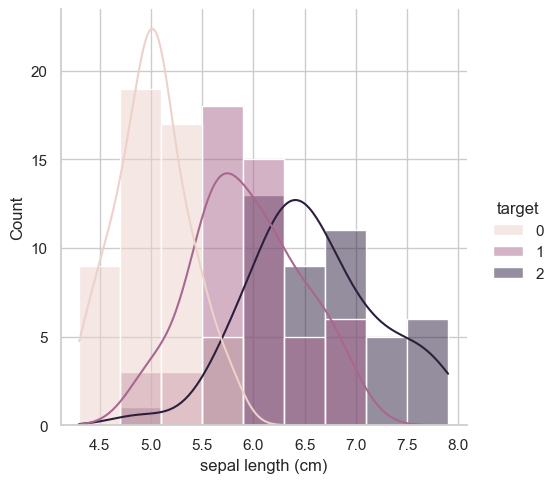

In [11]:
sns.displot(data=df, x="sepal length (cm)", hue="target", kde=True)

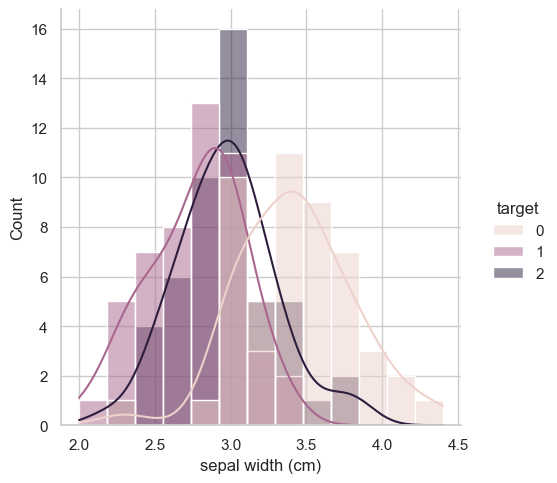

In [12]:
sns.displot(data=df, x="sepal width (cm)", hue="target", kde=True)

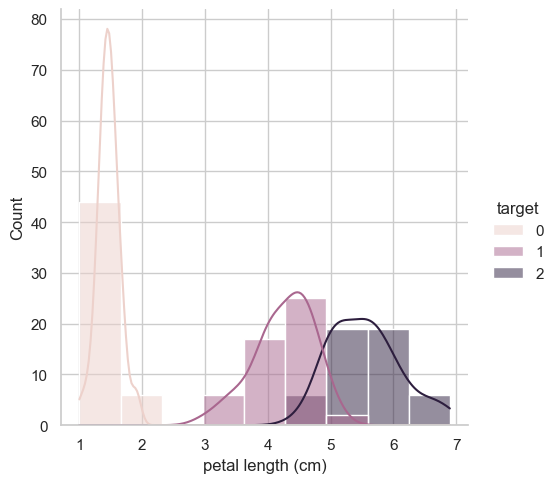

In [13]:
sns.displot(data=df, x="petal length (cm)", hue="target", kde=True)

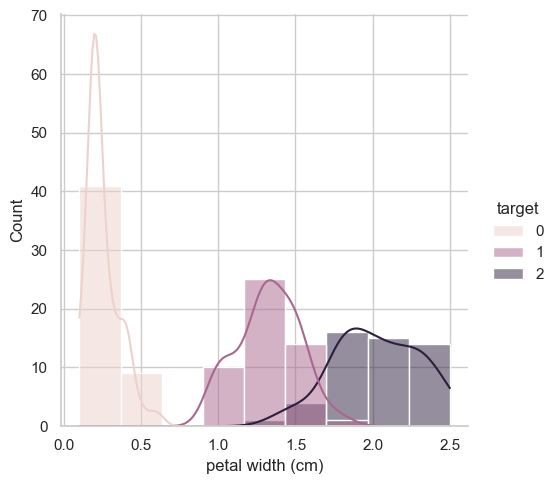

In [14]:
sns.displot(data=df, x="petal width (cm)", hue="target", kde=True)

У первых двух признаков распределение похоже на нормальное. А по двум последним Ирис-Сетоса сильно отличается от двух других своими лепестками.

Теперь рассмоттрим зависимоть признаков друг от друг ав зависимости от каждого вида:

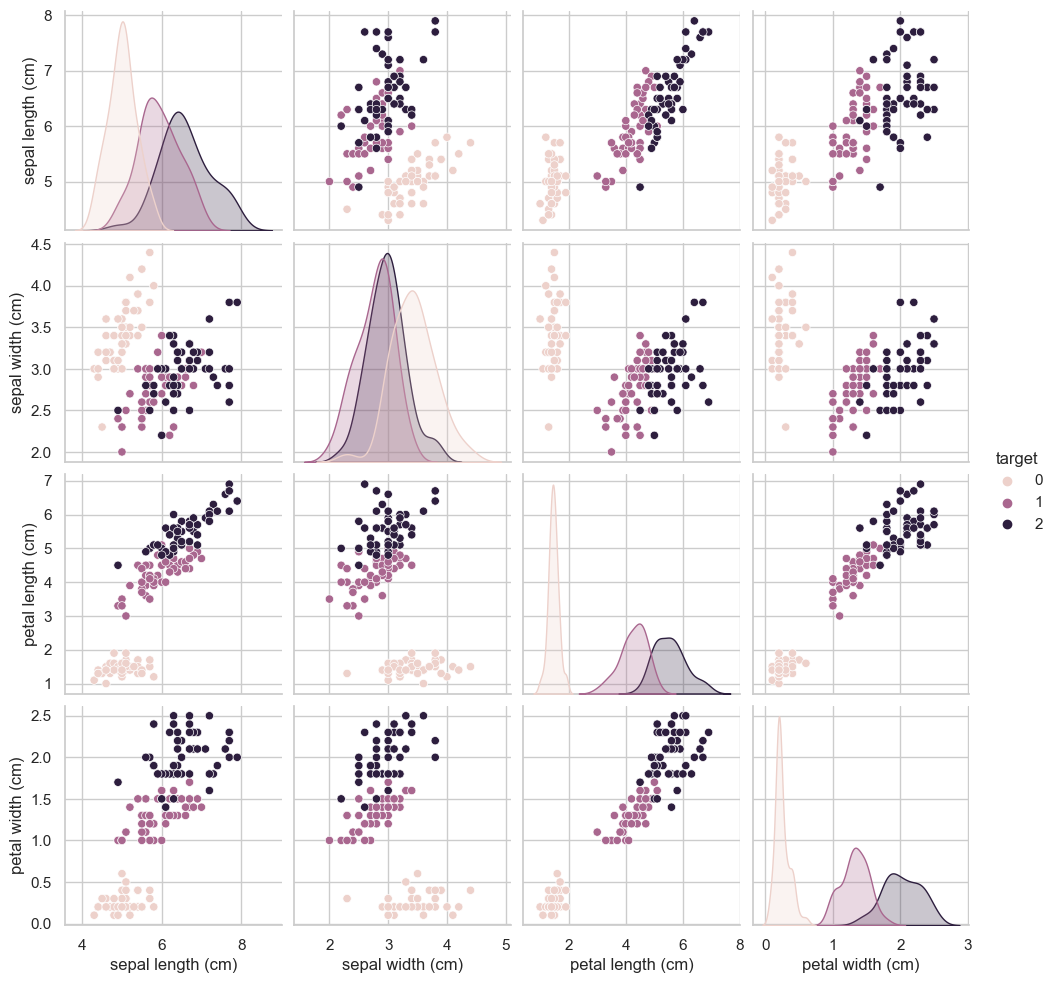

In [15]:
sns.pairplot(data=df, hue="target")

* Ширина и длина лепестка имееют линейную зависимоть
* Ирис вида 0 сильно отличается от вида 1 и 2, однако последние два имееют похожие значения признаков

[x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).

Разбиение данных на тестовую и обучающую выборки

In [17]:
from sklearn.model_selection import train_test_split

X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Масштабирование

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

Подбор наилучшего подмножетсва признаков (RFECV)

In [19]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import RidgeClassifierCV

rfecv = RFECV(estimator=RidgeClassifierCV())
rfecv.fit(X_train_scaled, y_train)

print(f"Optimal numbers of feature: {rfecv.n_features_}")
features = list(X_train_scaled.columns[rfecv.support_])
print(f"Selected features: {features}")

Optimal numbers of feature: 3
Selected features: ['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [20]:
X_train_scaled = X_train_scaled[features]
X_test_scaled = X_test_scaled[features]

Подбор гиперпараметров

In [21]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(5, shuffle=True, random_state=19)

KNN

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

neighbors_grid = [3,5,7,9,11]
params_knn = [{"n_neighbors": neighbors_grid}]

searcher_knn = GridSearchCV(KNeighborsClassifier(), params_knn, cv=cv, scoring="roc_auc_ovr", error_score="raise")
searcher_knn.fit(X_train_scaled, y_train)

optimal_n_neighbors_knn = searcher_knn.best_params_["n_neighbors"]
print(f"Neighbors: {optimal_n_neighbors_knn}")

Neighbors: 9


SVM

In [23]:
from sklearn.svm import SVC

kernel_grid = ["linear", "rbf"]
c_svm_grid = [0.1, 0.25, 0.5, 0.75, 1]
gamma_grid = ["scale", "auto"]
params_svm = [{"kernel": kernel_grid, 
               "C": c_svm_grid, 
               "gamma": gamma_grid}]

searcher_svm = GridSearchCV(SVC(random_state=19, probability=True), params_svm, cv=cv, scoring="roc_auc_ovr", error_score="raise")
searcher_svm.fit(X_train_scaled, y_train)

optimal_kernel = searcher_svm.best_params_["kernel"]
print(f"Kernel: {optimal_kernel}")
optimal_c_svm = searcher_svm.best_params_["C"]
print(f"C: {optimal_c_svm}")
optimal_gamma = searcher_svm.best_params_["gamma"]
print(f"Gamma: {optimal_gamma}")

Kernel: linear
C: 0.5
Gamma: scale


Logistic Regression (LG)

In [24]:
from sklearn.linear_model import LogisticRegression

c_lg_grid = np.arange(1e-05, 5, 1)
params_lg = [{"C" : c_lg_grid}]

searcher_lg = GridSearchCV(LogisticRegression(), params_lg, cv=cv, scoring="roc_auc_ovr", error_score="raise")
searcher_lg.fit(X_train_scaled, y_train)

optimal_c_lg = searcher_lg.best_params_["C"]
print(f"C: {optimal_c_lg}")

C: 2.00001


Naive Bayes (NB)

In [25]:
from sklearn.naive_bayes import GaussianNB

var_smoothing_grid = np.logspace(0, -9)
params_nb = [{"var_smoothing" : var_smoothing_grid}]

sercher_nb = GridSearchCV(GaussianNB(), params_nb, cv=cv, scoring="roc_auc_ovr", error_score="raise")
sercher_nb.fit(X_train_scaled, y_train)

optimal_var_smoothing = sercher_nb.best_params_["var_smoothing"]
print(f"var_smoothing: {optimal_var_smoothing}")

var_smoothing: 0.00021209508879201905


Decision Tree (DT)

In [26]:
from sklearn.tree import DecisionTreeClassifier

max_depth_grid = range(1, 11)
min_samples_leaf_grid = [2, 4, 6]
min_samples_split_grid = [2, 6, 6]
params_dt = [{"max_depth": max_depth_grid,
              "min_samples_leaf": min_samples_leaf_grid,
              "min_samples_split": min_samples_split_grid}]

searcher_dt = GridSearchCV(DecisionTreeClassifier(random_state=19), params_dt, cv=cv, scoring="roc_auc_ovr", error_score="raise")
searcher_dt.fit(X_train_scaled, y_train)

optimal_max_depth = searcher_dt.best_params_["max_depth"]
print(f"Max depth: {optimal_max_depth}")
optimal_min_samples_leaf = searcher_dt.best_params_["min_samples_leaf"]
print(f"Min samples leaf: {optimal_min_samples_leaf}")
optimal_min_samples_split = searcher_dt.best_params_["min_samples_split"]
print(f"Min samples split: {optimal_min_samples_split}")

Max depth: 5
Min samples leaf: 4
Min samples split: 2


[x] Используя стратегии **OneVsRest**, **OneVsOne** и **OutputCode** решите задачу **Multiclass classification** для каждого из пройденных базового алгоритма классификации (**logistic regression, svm, knn, naive bayes, decision tree**). При обучении использовать **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания.

[x] Замерить время обучения каждой модели для каждой стратегии.

In [27]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

accuracies = {}
times = {}

def time_model(model, X, y):
    t = cross_validate(model, X, y, cv=5)["fit_time"].mean()
    return t

In [28]:
knn = KNeighborsClassifier(optimal_n_neighbors_knn)
svm = SVC(kernel=optimal_kernel, C=optimal_c_svm, gamma=optimal_gamma, random_state=19)
lg = LogisticRegression(C=optimal_c_lg)
nb = GaussianNB(var_smoothing=optimal_var_smoothing)
dt = DecisionTreeClassifier(max_depth=optimal_max_depth, min_samples_leaf=optimal_min_samples_leaf, min_samples_split=optimal_min_samples_split, random_state=19)

Стратегия OneVsRest

In [29]:
from sklearn.multiclass import OneVsRestClassifier

KNN

In [30]:
knn_ovr = OneVsRestClassifier(knn).fit(X_train_scaled, y_train)
y_knn_ovr = knn_ovr.predict(X_test_scaled)

accuracies["knn_ovr"] = accuracy_score(y_test, y_knn_ovr)
times["knn_ovr"] = time_model(knn_ovr, X_train_scaled, y_train)

SVM

In [31]:
svm_ovr = OneVsRestClassifier(svm).fit(X_train_scaled, y_train)
y_svm_ovr = svm_ovr.predict(X_test_scaled)

accuracies["svm_ovr"] = accuracy_score(y_test, y_svm_ovr)
times["svm_ovr"] = time_model(svm_ovr, X_train_scaled, y_train)

LG

In [32]:
lg_ovr = OneVsRestClassifier(lg).fit(X_train_scaled, y_train)
y_lg_ovr = lg_ovr.predict(X_test_scaled)

accuracies["lg_ovr"] = accuracy_score(y_test, y_lg_ovr)
times["lg_ovr"] = time_model(lg_ovr, X_train_scaled, y_train)

NB

In [33]:
nb_ovr = OneVsRestClassifier(nb).fit(X_train_scaled, y_train)
y_nb_ovr = nb_ovr.predict(X_test_scaled)

accuracies["nb_ovr"] = accuracy_score(y_test, y_nb_ovr)
times["nb_ovr"] = time_model(nb_ovr, X_train_scaled, y_train)

DT

In [34]:
dt_ovr = OneVsRestClassifier(dt).fit(X_train_scaled, y_train)
y_dt_ovr = dt_ovr.predict(X_test_scaled)

accuracies["dt_ovr"] = accuracy_score(y_test, y_dt_ovr)
times["dt_ovr"] = time_model(dt_ovr, X_train_scaled, y_train)

Стратегия OneVsOne

In [35]:
from sklearn.multiclass import OneVsOneClassifier

KNN

In [36]:
knn_ovo = OneVsOneClassifier(knn).fit(X_train_scaled, y_train)
y_knn_ovo = knn_ovo.predict(X_test_scaled)

accuracies["knn_ovo"] = accuracy_score(y_test, y_knn_ovo)
times["knn_ovo"] = time_model(knn_ovo, X_train_scaled, y_train)

SVM

In [37]:
svm_ovo = OneVsOneClassifier(svm).fit(X_train_scaled, y_train)
y_svm_ovo = svm_ovo.predict(X_test_scaled)

accuracies["svm_ovo"] = accuracy_score(y_test, y_svm_ovo)
times["svm_ovo"] = time_model(svm_ovo, X_train_scaled, y_train)

LG

In [38]:
lg_ovo = OneVsOneClassifier(lg).fit(X_train_scaled, y_train)
y_lg_ovo = lg_ovo.predict(X_test_scaled)

accuracies["lg_ovo"] = accuracy_score(y_test, y_lg_ovo)
times["lg_ovo"] = time_model(lg_ovo, X_train_scaled, y_train)

NB

In [39]:
nb_ovo = OneVsOneClassifier(nb).fit(X_train_scaled, y_train)
y_nb_ovo = nb_ovo.predict(X_test_scaled)

accuracies["nb_ovo"] = accuracy_score(y_test, y_nb_ovo)
times["nb_ovo"] = time_model(nb_ovo, X_train_scaled, y_train)

DT

In [40]:
dt_ovo = OneVsRestClassifier(dt).fit(X_train_scaled, y_train)
y_dt_ovo = dt_ovo.predict(X_test_scaled)

accuracies["dt_ovo"] = accuracy_score(y_test, y_dt_ovo)
times["dt_ovo"] = time_model(dt_ovo, X_train_scaled, y_train)

Стратегия OutputCode

In [41]:
from sklearn.multiclass import OutputCodeClassifier

KNN

In [42]:
knn_oc = OutputCodeClassifier(knn).fit(X_train_scaled, y_train)
y_knn_oc = knn_oc.predict(X_test_scaled)

accuracies["knn_oc"] = accuracy_score(y_test, y_knn_oc)
times["knn_oc"] = time_model(knn_oc, X_train_scaled, y_train)

SVM

In [43]:
svm_oc = OutputCodeClassifier(svm).fit(X_train_scaled, y_train)
y_svm_oc = svm_oc.predict(X_test_scaled)

accuracies["svm_oc"] = accuracy_score(y_test, y_svm_oc)
times["svm_oc"] = time_model(svm_oc, X_train_scaled, y_train)

LG

In [44]:
lg_oc = OutputCodeClassifier(lg).fit(X_train_scaled, y_train)
y_lg_oc = lg_oc.predict(X_test_scaled)

accuracies["lg_oc"] = accuracy_score(y_test, y_lg_oc)
times["lg_oc"] = time_model(lg_oc, X_train_scaled, y_train)

NB

In [45]:
nb_oc = OneVsRestClassifier(nb).fit(X_train_scaled, y_train)
y_nb_oc = nb_oc.predict(X_test_scaled)

accuracies["nb_oc"] = accuracy_score(y_test, y_nb_oc)
times["nb_oc"] = time_model(nb_oc, X_train_scaled, y_train)

DT

In [46]:
dt_oc = OneVsRestClassifier(dt).fit(X_train_scaled, y_train)
y_dt_oc = dt_oc.predict(X_test_scaled)

accuracies["dt_oc"] = accuracy_score(y_test, y_dt_oc)
times["dt_oc"] = time_model(dt_oc, X_train_scaled, y_train)

[x] Сравнить время обучения и качество всех моделей и всех стратегий. Сделать выводы.

Точность:

<AxesSubplot: xlabel='algorithms', ylabel='accuracy'>

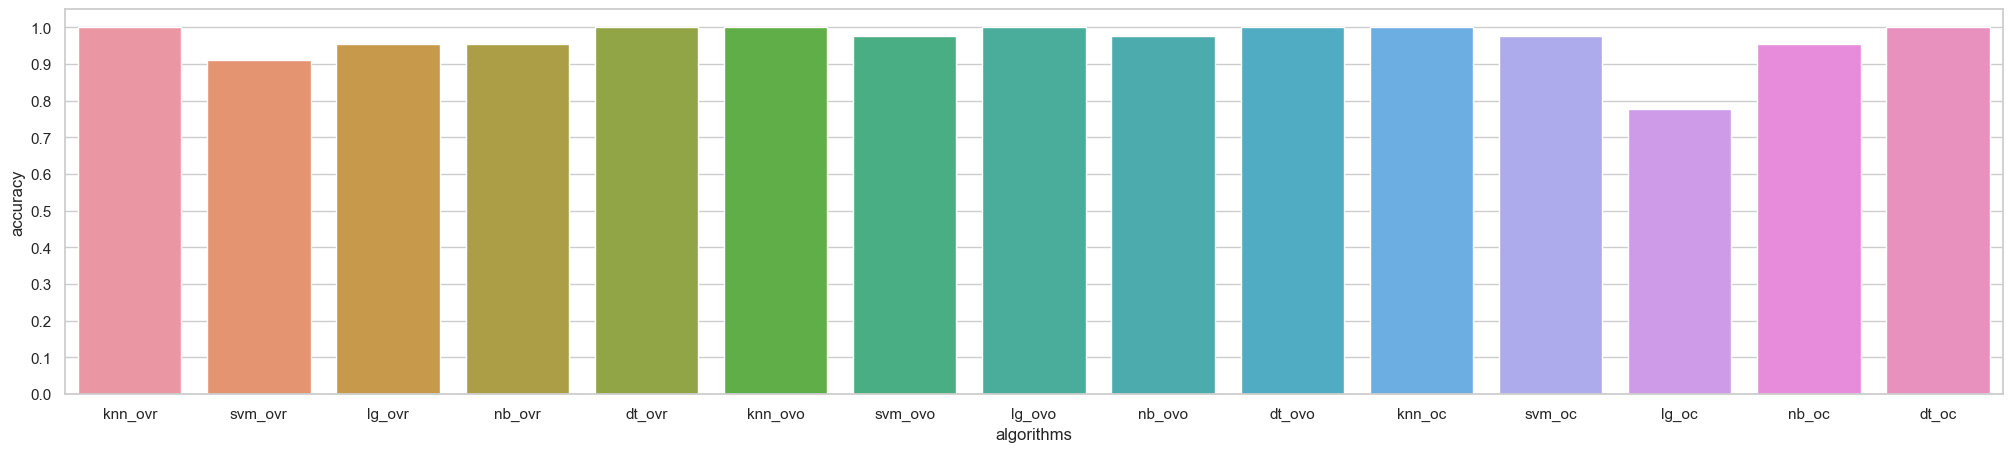

In [47]:
plt.figure(figsize=(25, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("accuracy")
plt.xlabel("algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))

Наибольшую точность показала стратегия OneVsOne. Наименее же точной - OutpuCode.

Время:

<AxesSubplot: xlabel='algorithms', ylabel='time'>

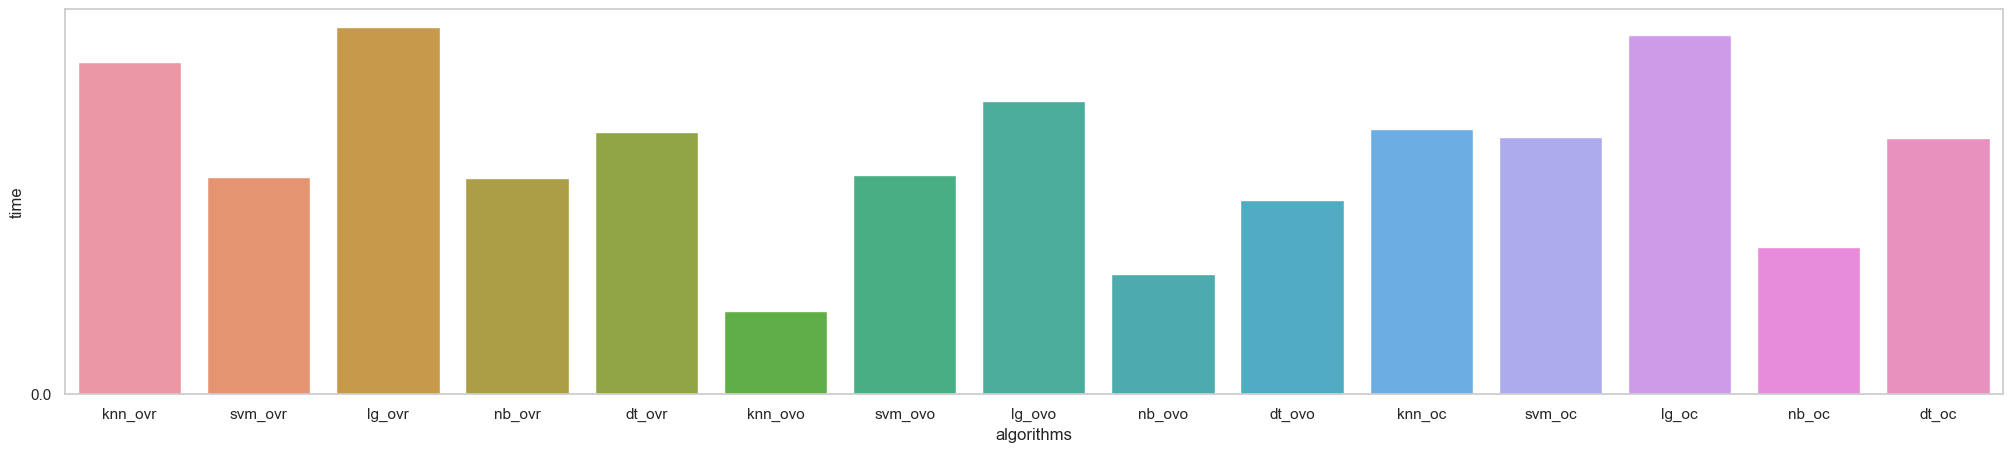

In [48]:
sns.set_style("whitegrid")
plt.figure(figsize=(25, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("time")
plt.xlabel("algorithms")
sns.barplot(x=list(times.keys()), y=list(times.values()))

Наименьшее время исполнения затрачивает стратегия OneVsOne. Наибольшее - OneVsRest.

Самой точной и быстрой по времени стала реализация KNN. Обратный результат - Logistic Regression.